In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import sparselt.esmf
import sparselt.xr
import mf2w
from tqdm.dask import TqdmCallback

C:\Users\liamb\anaconda3\envs\py39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tavg_ctm = xr.open_dataset("data/GEOS.fp.asm.tavg_3hr_ctm_c0720_v72.20210401_0130.V01.nc")
# with TqdmCallback(desc="compute"):
# tavg_3hr_ctm = xr.open_mfdataset(["data/GEOS.fp.asm.tavg_1hr_ctm_c0720_v72.20210401_0030.V01.nc4",
#                                   "data/GEOS.fp.asm.tavg_1hr_ctm_c0720_v72.20210401_0130.V01.nc4",
#                                   "data/GEOS.fp.asm.tavg_1hr_ctm_c0720_v72.20210401_0230.V01.nc4"], data_vars=['MFXC', 'MFYC', 'DELP'], compat='override', coords=['time'])
# tavg_3hr_ctm = tavg_3hr_ctm.drop(['cubed_sphere', 'contacts', 'orientation', 'anchor', 'TAITIME', 'PS'])
# tavg_3hr_ctm = tavg_3hr_ctm.mean(dim=['time']).expand_dims(dim='time', axis=0)
# from dask.diagnostics import ProgressBar
# delayed = tavg_3hr_ctm.to_netcdf("data/GEOS.fp.asm.tavg_3hr_ctm_c0720_v72.20210401_0130.V01.nc", compute=False)
# with ProgressBar():
#     delayed.compute()
    
grid = xr.open_mfdataset([f"data/c720.tile{n}.nc" for n in range(1,7)], concat_dim='nf', combine='nested')
tavg_1hr_winds = mf2w.convert_mass_fluxes_to_wind(tavg_ctm, grid, change_of_basis='ronchi')

Processing: 100%|██████████| 6/6 [00:47<00:00,  7.90s/cube_sphere_face]


In [3]:
transform = sparselt.esmf.load_weights(
    'data/weights_cs2ll.nc',
    input_dims=[('nf', 'Ydim', 'Xdim'), (6, 720, 720)],
    output_dims=[('lat', 'lon'), (721, 1152)],
)
tavg_1hr_winds_ll = sparselt.xr.apply(transform, tavg_1hr_winds)

In [4]:
latlon_grid = xr.open_dataset("data/regular_lat_lon_721x1152.nc")
tavg3_3d_asm = xr.open_dataset("data/GEOS.fp.asm.tavg3_3d_asm_Nv.20210401_0130.V01.nc4")
x = latlon_grid.lon
y = latlon_grid.lat

RMSE: 0.22201468542274402
RMSE: 0.2193748038359854
RMSE: 0.2595727381064832


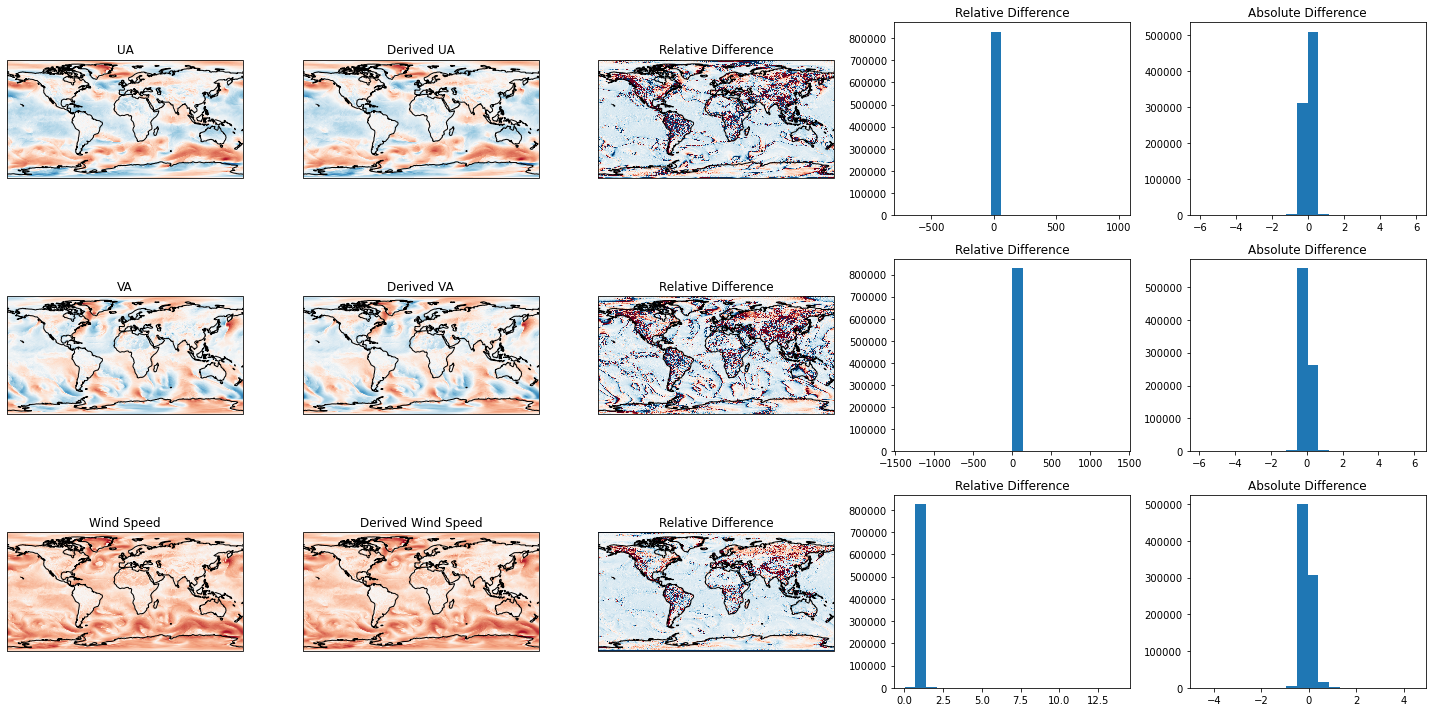

In [5]:
%matplotlib inline

norm = plt.Normalize(-30, 30)

plt.figure(figsize=(20,10))


expected=tavg3_3d_asm.U[0,-1,:,:]
calculated=tavg_1hr_winds_ll.UA[0,-1,:,:]
#relative_difference = (calculated-expected)/np.maximum(np.abs(calculated), np.abs(expected))
relative_difference=(calculated/expected)
rmse = np.sqrt(np.mean((calculated-expected)**2)).item()
print(f"RMSE: {rmse}")

ax = plt.subplot(3,5,1, projection=ccrs.PlateCarree())
ax.coastlines()
plt.title("UA")
plt.pcolormesh(x, y, expected, norm=norm, cmap='RdBu_r')

ax = plt.subplot(3,5,2, projection=ccrs.PlateCarree())
ax.coastlines()
plt.title("Derived UA")
plt.pcolormesh(x, y, calculated, norm=norm, cmap='RdBu_r')

ax = plt.subplot(3,5,3, projection=ccrs.PlateCarree())
ax.coastlines()
plt.title("Relative Difference")
plt.pcolormesh(x, y, relative_difference, norm=plt.Normalize(0.9, 1.1), cmap='RdBu_r')

ax = plt.subplot(3,5,4)
plt.title("Relative Difference")
plt.hist(relative_difference.values.flatten(), bins=20)
ax = plt.subplot(3,5,5)
plt.title("Absolute Difference")
plt.hist((calculated-expected).values.flatten(), bins=20)

expected=tavg3_3d_asm.V[0,-1,:,:]
calculated=tavg_1hr_winds_ll.VA[0,-1,:,:]
#relative_difference = (calculated-expected)/np.maximum(np.abs(calculated), np.abs(expected))
relative_difference=(calculated/expected)
rmse = np.sqrt(np.mean((calculated-expected)**2)).item()
print(f"RMSE: {rmse}")

ax = plt.subplot(3,5,6, projection=ccrs.PlateCarree())
ax.coastlines()
plt.title("VA")
plt.pcolormesh(x, y, expected, norm=norm, cmap='RdBu_r')

ax = plt.subplot(3,5,7, projection=ccrs.PlateCarree())
ax.coastlines()
plt.title("Derived VA")
plt.pcolormesh(x, y, calculated, norm=norm, cmap='RdBu_r')

ax = plt.subplot(3,5,8, projection=ccrs.PlateCarree())
ax.coastlines()
plt.title("Relative Difference")
plt.pcolormesh(x, y, relative_difference, norm=plt.Normalize(0.9, 1.1), cmap='RdBu_r')

ax = plt.subplot(3,5,9)
plt.title("Relative Difference")
plt.hist(relative_difference.values.flatten(), bins=20)
ax = plt.subplot(3,5,10)
plt.title("Absolute Difference")
plt.hist((calculated-expected).values.flatten(), bins=20)

expected=np.sqrt(tavg3_3d_asm.U[0,-1,:,:]**2 + tavg3_3d_asm.V[0,-1,:,:]**2)
calculated=np.sqrt(tavg_1hr_winds_ll.UA[0,-1,:,:]**2 + tavg_1hr_winds_ll.VA[0,-1,:,:]**2)
#relative_difference = (calculated-expected)/np.maximum(np.abs(calculated), np.abs(expected))
relative_difference=(calculated/expected)
rmse = np.sqrt(np.mean((calculated-expected)**2)).item()
print(f"RMSE: {rmse}")

ax = plt.subplot(3,5,11, projection=ccrs.PlateCarree())
ax.coastlines()
plt.title("Wind Speed")
plt.pcolormesh(x, y, expected, norm=norm, cmap='RdBu_r')

ax = plt.subplot(3,5,12, projection=ccrs.PlateCarree())
ax.coastlines()
plt.title("Derived Wind Speed")
plt.pcolormesh(x, y, calculated, norm=norm, cmap='RdBu_r')

ax = plt.subplot(3,5,13, projection=ccrs.PlateCarree())
ax.coastlines()
plt.title("Relative Difference")
plt.pcolormesh(x, y, relative_difference, norm=plt.Normalize(0.9, 1.1), cmap='RdBu_r')

ax = plt.subplot(3,5,14)
plt.title("Relative Difference")
plt.hist(relative_difference.values.flatten(), bins=20)
ax = plt.subplot(3,5,15)
plt.title("Absolute Difference")
plt.hist((calculated-expected).values.flatten(), bins=20)

plt.tight_layout()

[########################################] | 100% Completed |  2min  3.9s
